# 資料探勘作業二 - 吸菸預測

## 1. 導入必要的套件

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

# 用於儲存中間結果的目錄
import os
if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')

## 2. 載入資料

In [3]:
# 讀取資料
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("Initial shapes:")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# 儲存原始資料
with open('model_checkpoints/raw_data.pkl', 'wb') as f:
    pickle.dump({'train': train, 'test': test}, f)

Initial shapes:
Train shape: (15000, 24)
Test shape: (10000, 23)


## 3. 資料預處理

In [4]:
# 合併訓練和測試資料
test['smoking'] = np.nan
data = pd.concat([train, test], ignore_index=True)
print("Combined data shape:", data.shape)

# 填補缺失值
imputer = SimpleImputer(strategy='median')
data.iloc[:, :] = imputer.fit_transform(data)

# 移除欄位名稱中的空格
data.columns = data.columns.str.replace(' ', '_')

# 識別數值型和類別型欄位
categorical_columns = ['hearing(left)', 'hearing(right)', 'Urine_protein', 'dental_caries']
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in ['smoking']]

print("\nNumerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

# 儲存預處理後的數據和轉換器
with open('model_checkpoints/preprocessed_data.pkl', 'wb') as f:
    pickle.dump({'data': data, 'numerical_columns': numerical_columns, 
                'categorical_columns': categorical_columns}, f)

Combined data shape: (25000, 24)

Numerical columns: ['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting_blood_sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine_protein', 'serum_creatinine', 'AST', 'ALT', 'Gtp', 'dental_caries']
Categorical columns: ['hearing(left)', 'hearing(right)', 'Urine_protein', 'dental_caries']


## 4. 特徵工程

In [5]:
# 處理數值型特徵
scaler = MinMaxScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
data[numerical_columns] = power_transformer.fit_transform(data[numerical_columns])
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# OneHot編碼
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(data[categorical_columns])
encoded_df = pd.DataFrame(
    encoded, 
    columns=encoder.get_feature_names_out(categorical_columns),
    index=data.index
)

# 移除原始類別型欄位並加入編碼後的欄位
data = data.drop(columns=categorical_columns)
data = pd.concat([data, encoded_df], axis=1)

# 新增KMeans聚類特徵
kmeans = KMeans(n_clusters=5, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(data.drop(columns=['smoking']))

# 儲存特徵工程後的數據和轉換器
with open('model_checkpoints/feature_engineering.pkl', 'wb') as f:
    pickle.dump({
        'data': data,
        'scaler': scaler,
        'power_transformer': power_transformer,
        'encoder': encoder,
        'kmeans': kmeans
    }, f)

Exception in thread Thread-3 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xaa in position 24: invalid start byte
c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could 

## 5. 資料分割

In [6]:
# 取得原始資料長度
train_length = len(train)
test_length = len(test)

# 分割資料
X_train = data.iloc[:train_length].drop(columns=['smoking'])
X_test = data.iloc[train_length:].drop(columns=['smoking'])
y_train = data.iloc[:train_length]['smoking'].astype(int)

print("Final shapes:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)

# 儲存分割後的資料
with open('model_checkpoints/split_data.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train
    }, f)

Final shapes:
X_train shape: (15000, 24)
X_test shape: (10000, 24)
y_train shape: (15000,)


## 6. 模型訓練與交叉驗證

In [7]:
# 初始化模型
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_model = XGBClassifier(tree_method='hist', eval_metric='logloss', use_label_encoder=False, base_score=0.5)
lgbm_model = LGBMClassifier(objective='binary')
catboost_model = CatBoostClassifier(verbose=0)

# 初始化預測結果陣列
xgb_preds = np.zeros(len(X_test))
lgbm_preds = np.zeros(len(X_test))
catboost_preds = np.zeros(len(X_test))

# 追蹤每一折的驗證分數
validation_scores = {
    'xgb': [],
    'lgbm': [],
    'catboost': []
}

# 交叉驗證訓練
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\nFold {fold}")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # XGBoost
    try:
        xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
        xgb_preds += xgb_model.predict_proba(X_test)[:, 1] / skf.n_splits
        validation_scores['xgb'].append(xgb_model.score(X_val, y_val))
        print(f"XGBoost validation score: {validation_scores['xgb'][-1]:.4f}")
    except Exception as e:
        print(f"XGBoost training error: {e}")
    
    # LightGBM
    try:
        lgbm_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
        lgbm_preds += lgbm_model.predict_proba(X_test)[:, 1] / skf.n_splits
        validation_scores['lgbm'].append(lgbm_model.score(X_val, y_val))
        print(f"LightGBM validation score: {validation_scores['lgbm'][-1]:.4f}")
    except Exception as e:
        print(f"LightGBM training error: {e}")
    
    # CatBoost
    try:
        catboost_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
        catboost_preds += catboost_model.predict_proba(X_test)[:, 1] / skf.n_splits
        validation_scores['catboost'].append(catboost_model.score(X_val, y_val))
        print(f"CatBoost validation score: {validation_scores['catboost'][-1]:.4f}")
    except Exception as e:
        print(f"CatBoost training error: {e}")
    
    # 儲存每一折的模型和預測結果
    with open(f'model_checkpoints/fold_{fold}_models.pkl', 'wb') as f:
        pickle.dump({
            'xgb_model': xgb_model,
            'lgbm_model': lgbm_model,
            'catboost_model': catboost_model,
            'validation_scores': validation_scores
        }, f)

# 儲存所有預測結果
with open('model_checkpoints/predictions.pkl', 'wb') as f:
    pickle.dump({
        'xgb_preds': xgb_preds,
        'lgbm_preds': lgbm_preds,
        'catboost_preds': catboost_preds,
        'validation_scores': validation_scores
    }, f)


Fold 1
[0]	validation_0-logloss:0.58808
[1]	validation_0-logloss:0.52876
[2]	validation_0-logloss:0.49145
[3]	validation_0-logloss:0.46989
[4]	validation_0-logloss:0.45305
[5]	validation_0-logloss:0.44380
[6]	validation_0-logloss:0.43528
[7]	validation_0-logloss:0.42983
[8]	validation_0-logloss:0.42506
[9]	validation_0-logloss:0.42045
[10]	validation_0-logloss:0.41889
[11]	validation_0-logloss:0.41828
[12]	validation_0-logloss:0.41729
[13]	validation_0-logloss:0.41562
[14]	validation_0-logloss:0.41552
[15]	validation_0-logloss:0.41493
[16]	validation_0-logloss:0.41446
[17]	validation_0-logloss:0.41412
[18]	validation_0-logloss:0.41346
[19]	validation_0-logloss:0.41348
[20]	validation_0-logloss:0.41361
[21]	validation_0-logloss:0.41374
[22]	validation_0-logloss:0.41316


c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:37:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[23]	validation_0-logloss:0.41288
[24]	validation_0-logloss:0.41236
[25]	validation_0-logloss:0.41236
[26]	validation_0-logloss:0.41319
[27]	validation_0-logloss:0.41288
[28]	validation_0-logloss:0.41307
[29]	validation_0-logloss:0.41325
[30]	validation_0-logloss:0.41337
[31]	validation_0-logloss:0.41401
[32]	validation_0-logloss:0.41583
[33]	validation_0-logloss:0.41566
[34]	validation_0-logloss:0.41613
[35]	validation_0-logloss:0.41611
[36]	validation_0-logloss:0.41668
[37]	validation_0-logloss:0.41789
[38]	validation_0-logloss:0.41943
[39]	validation_0-logloss:0.42042
[40]	validation_0-logloss:0.41955
[41]	validation_0-logloss:0.41921
[42]	validation_0-logloss:0.41965
[43]	validation_0-logloss:0.41974
[44]	validation_0-logloss:0.42021
[45]	validation_0-logloss:0.42045
[46]	validation_0-logloss:0.42255
[47]	validation_0-logloss:0.42281
[48]	validation_0-logloss:0.42291
[49]	validation_0-logloss:0.42327
[50]	validation_0-logloss:0.42315
[51]	validation_0-logloss:0.42375
[52]	validatio

c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:37:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[19]	validation_0-logloss:0.41457
[20]	validation_0-logloss:0.41434
[21]	validation_0-logloss:0.41424
[22]	validation_0-logloss:0.41539
[23]	validation_0-logloss:0.41584
[24]	validation_0-logloss:0.41556
[25]	validation_0-logloss:0.41546
[26]	validation_0-logloss:0.41521
[27]	validation_0-logloss:0.41494
[28]	validation_0-logloss:0.41490
[29]	validation_0-logloss:0.41508
[30]	validation_0-logloss:0.41525
[31]	validation_0-logloss:0.41500
[32]	validation_0-logloss:0.41516
[33]	validation_0-logloss:0.41476
[34]	validation_0-logloss:0.41529
[35]	validation_0-logloss:0.41526
[36]	validation_0-logloss:0.41578
[37]	validation_0-logloss:0.41556
[38]	validation_0-logloss:0.41494
[39]	validation_0-logloss:0.41510
[40]	validation_0-logloss:0.41558
[41]	validation_0-logloss:0.41568
[42]	validation_0-logloss:0.41566
[43]	validation_0-logloss:0.41580
[44]	validation_0-logloss:0.41561
[45]	validation_0-logloss:0.41502
[46]	validation_0-logloss:0.41494
[47]	validation_0-logloss:0.41601
[48]	validatio

c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:38:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[19]	validation_0-logloss:0.41919
[20]	validation_0-logloss:0.41948
[21]	validation_0-logloss:0.41866
[22]	validation_0-logloss:0.41909
[23]	validation_0-logloss:0.41898
[24]	validation_0-logloss:0.41891
[25]	validation_0-logloss:0.41824
[26]	validation_0-logloss:0.41808
[27]	validation_0-logloss:0.41870
[28]	validation_0-logloss:0.41902
[29]	validation_0-logloss:0.41963
[30]	validation_0-logloss:0.42038
[31]	validation_0-logloss:0.42074
[32]	validation_0-logloss:0.42075
[33]	validation_0-logloss:0.42181
[34]	validation_0-logloss:0.42201
[35]	validation_0-logloss:0.42208
[36]	validation_0-logloss:0.42236
[37]	validation_0-logloss:0.42422
[38]	validation_0-logloss:0.42433
[39]	validation_0-logloss:0.42425
[40]	validation_0-logloss:0.42474
[41]	validation_0-logloss:0.42526
[42]	validation_0-logloss:0.42498
[43]	validation_0-logloss:0.42523
[44]	validation_0-logloss:0.42547
[45]	validation_0-logloss:0.42541
[46]	validation_0-logloss:0.42550
[47]	validation_0-logloss:0.42495
[48]	validatio

c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:38:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[20]	validation_0-logloss:0.40763
[21]	validation_0-logloss:0.40753
[22]	validation_0-logloss:0.40724
[23]	validation_0-logloss:0.40703
[24]	validation_0-logloss:0.40735
[25]	validation_0-logloss:0.40715
[26]	validation_0-logloss:0.40675
[27]	validation_0-logloss:0.40709
[28]	validation_0-logloss:0.40619
[29]	validation_0-logloss:0.40704
[30]	validation_0-logloss:0.40711
[31]	validation_0-logloss:0.40697
[32]	validation_0-logloss:0.40758
[33]	validation_0-logloss:0.40785
[34]	validation_0-logloss:0.40877
[35]	validation_0-logloss:0.40875
[36]	validation_0-logloss:0.40846
[37]	validation_0-logloss:0.40777
[38]	validation_0-logloss:0.40872
[39]	validation_0-logloss:0.41007
[40]	validation_0-logloss:0.40976
[41]	validation_0-logloss:0.41055
[42]	validation_0-logloss:0.41103
[43]	validation_0-logloss:0.41123
[44]	validation_0-logloss:0.41168
[45]	validation_0-logloss:0.41195
[46]	validation_0-logloss:0.41218
[47]	validation_0-logloss:0.41259
[48]	validation_0-logloss:0.41291
[49]	validatio

c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:38:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[20]	validation_0-logloss:0.41825
[21]	validation_0-logloss:0.41797
[22]	validation_0-logloss:0.41820
[23]	validation_0-logloss:0.41756
[24]	validation_0-logloss:0.41699
[25]	validation_0-logloss:0.41850
[26]	validation_0-logloss:0.41860
[27]	validation_0-logloss:0.41835
[28]	validation_0-logloss:0.41840
[29]	validation_0-logloss:0.41878
[30]	validation_0-logloss:0.41897
[31]	validation_0-logloss:0.41900
[32]	validation_0-logloss:0.41864
[33]	validation_0-logloss:0.41853
[34]	validation_0-logloss:0.41926
[35]	validation_0-logloss:0.41958
[36]	validation_0-logloss:0.41963
[37]	validation_0-logloss:0.42008
[38]	validation_0-logloss:0.42003
[39]	validation_0-logloss:0.42062
[40]	validation_0-logloss:0.42001
[41]	validation_0-logloss:0.41998
[42]	validation_0-logloss:0.42008
[43]	validation_0-logloss:0.42035
[44]	validation_0-logloss:0.42051
[45]	validation_0-logloss:0.42041
[46]	validation_0-logloss:0.42069
[47]	validation_0-logloss:0.42041
[48]	validation_0-logloss:0.42050
[49]	validatio

## 7. 模型融合與輸出結果

In [8]:
# 加權平均融合
final_preds = 0.34 * xgb_preds + 0.33 * lgbm_preds + 0.33 * catboost_preds

# 輸出預測結果
sample_submission['smoking'] = final_preds
sample_submission.to_csv('submission.csv', index=False)

print("\nFinal validation scores (mean):")
print(f"XGBoost: {np.mean(validation_scores['xgb']):.4f}")
print(f"LightGBM: {np.mean(validation_scores['lgbm']):.4f}")
print(f"CatBoost: {np.mean(validation_scores['catboost']):.4f}")


Final validation scores (mean):
XGBoost: 0.7885
LightGBM: 0.7979
CatBoost: 0.8002


## 8. 資料視覺化與分析

In [15]:
print(train_data.columns)

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')


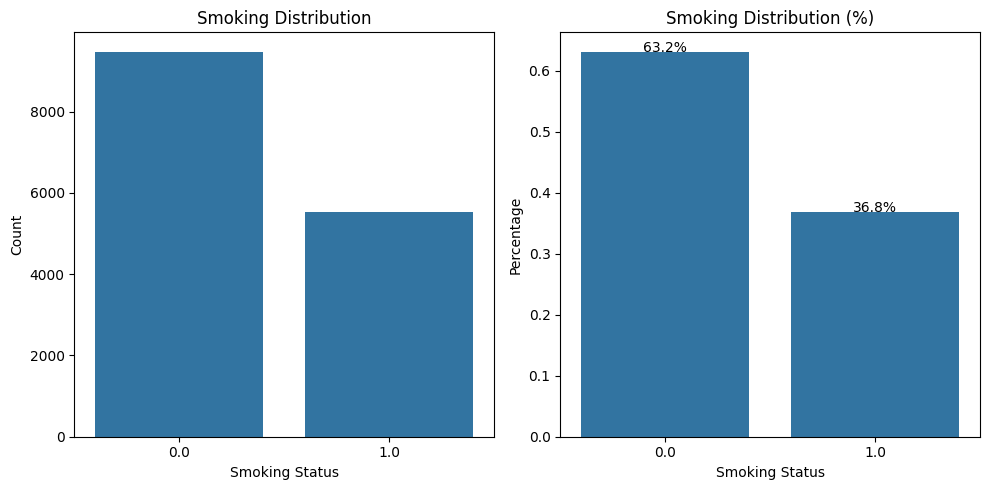

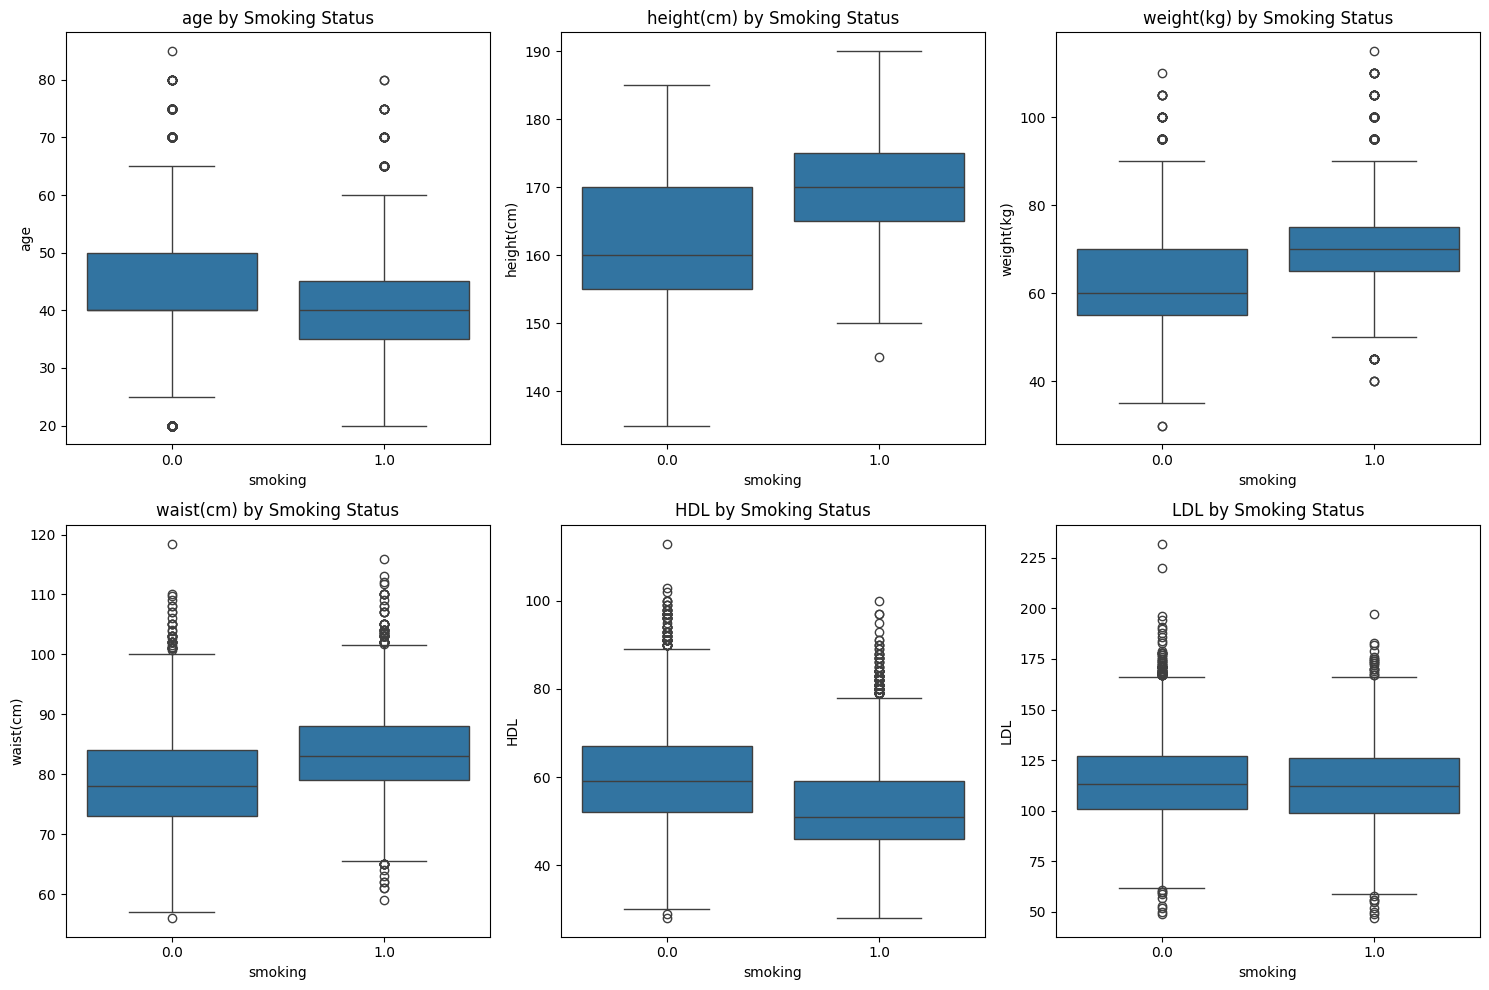

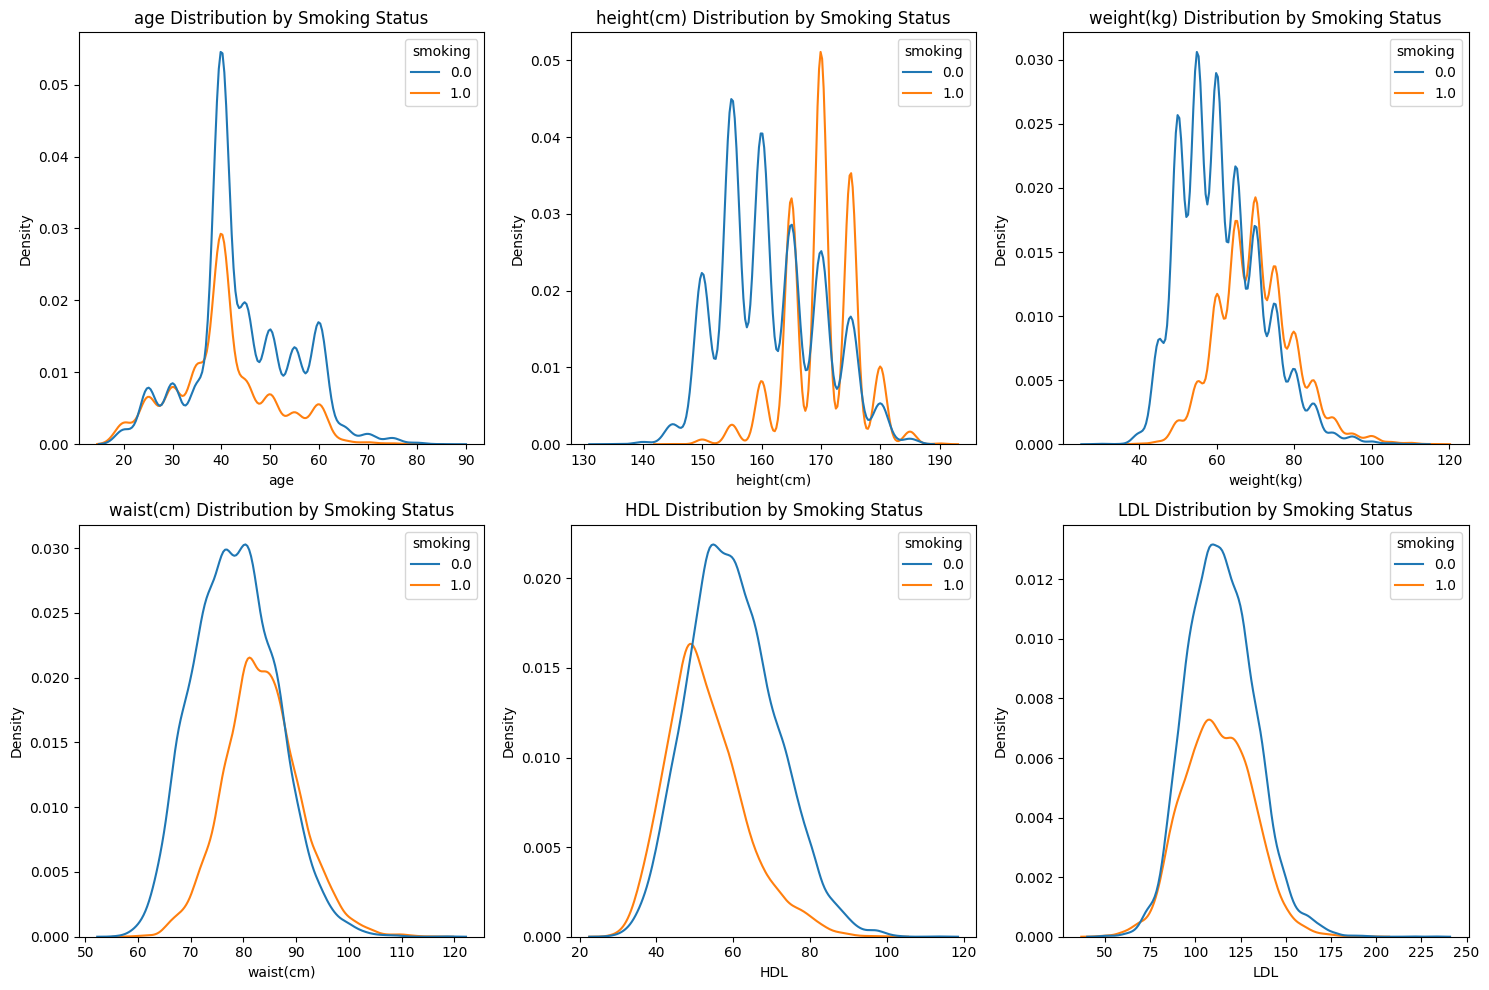

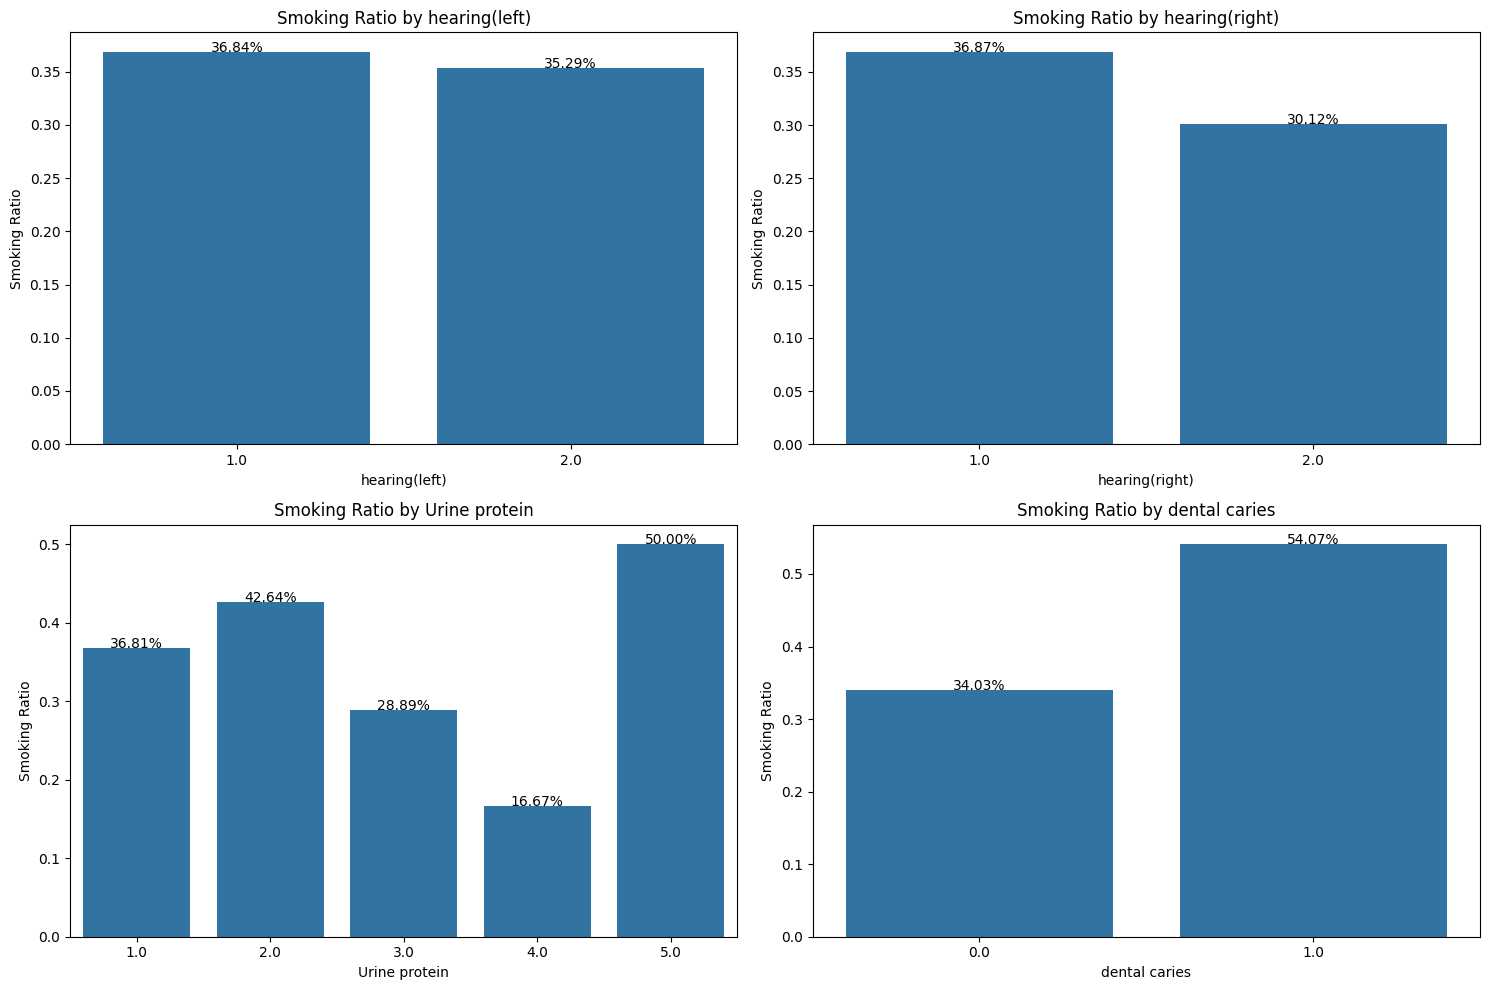

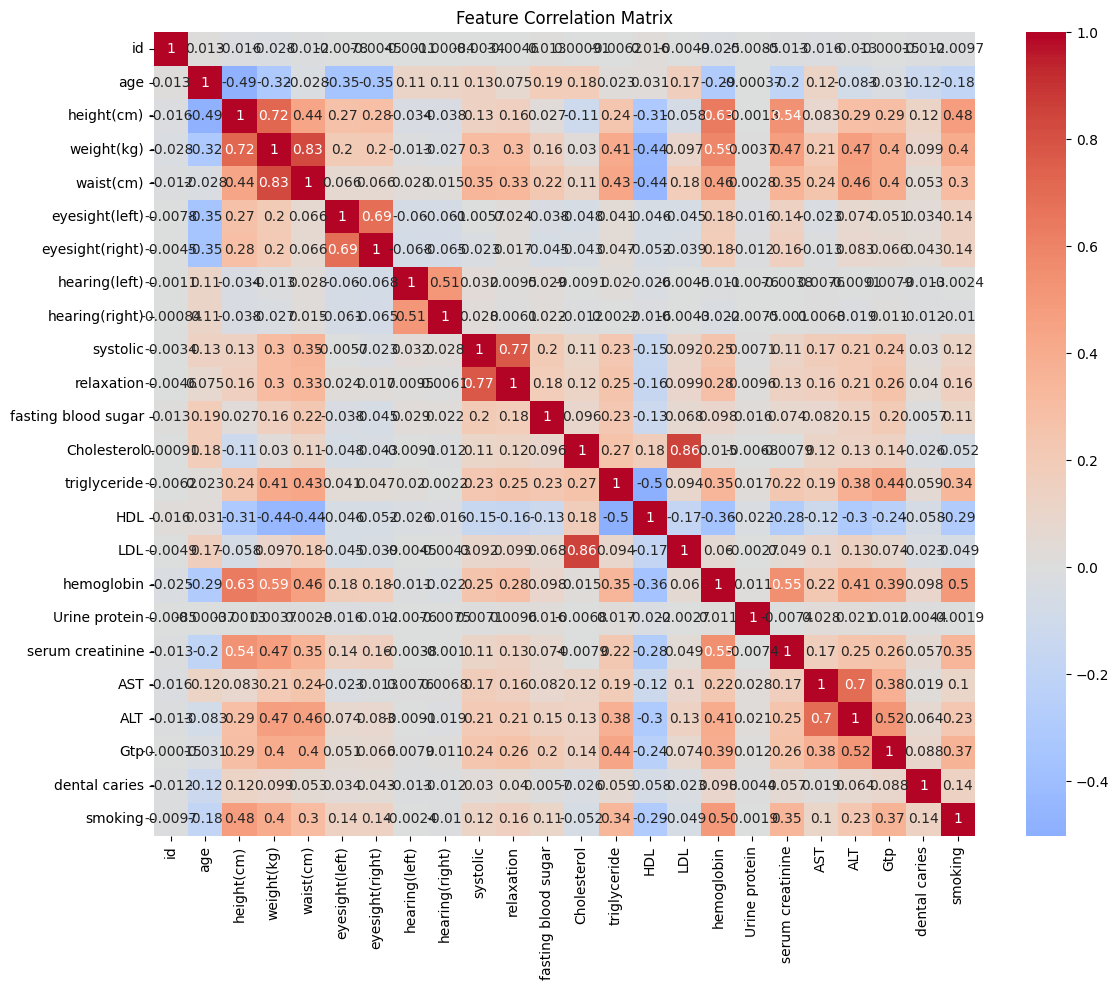

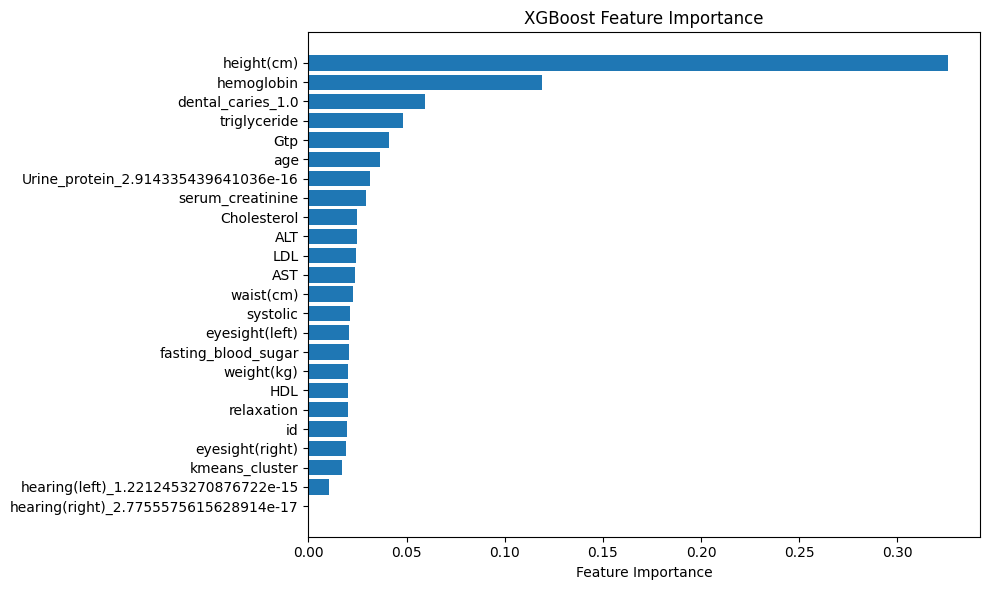

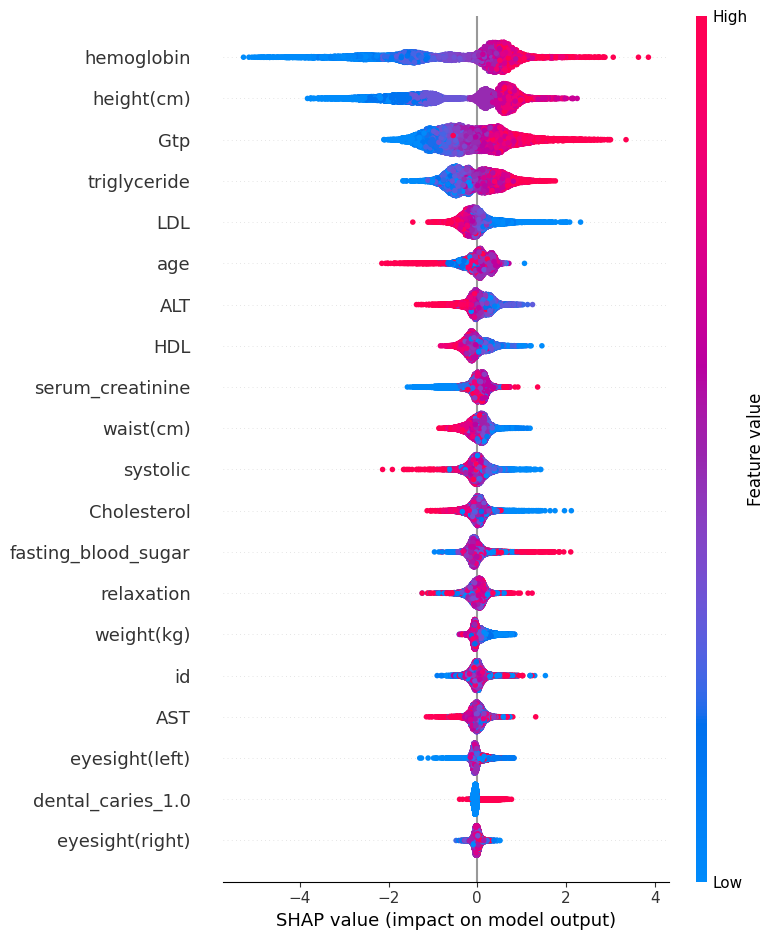

<Figure size 640x480 with 0 Axes>

c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


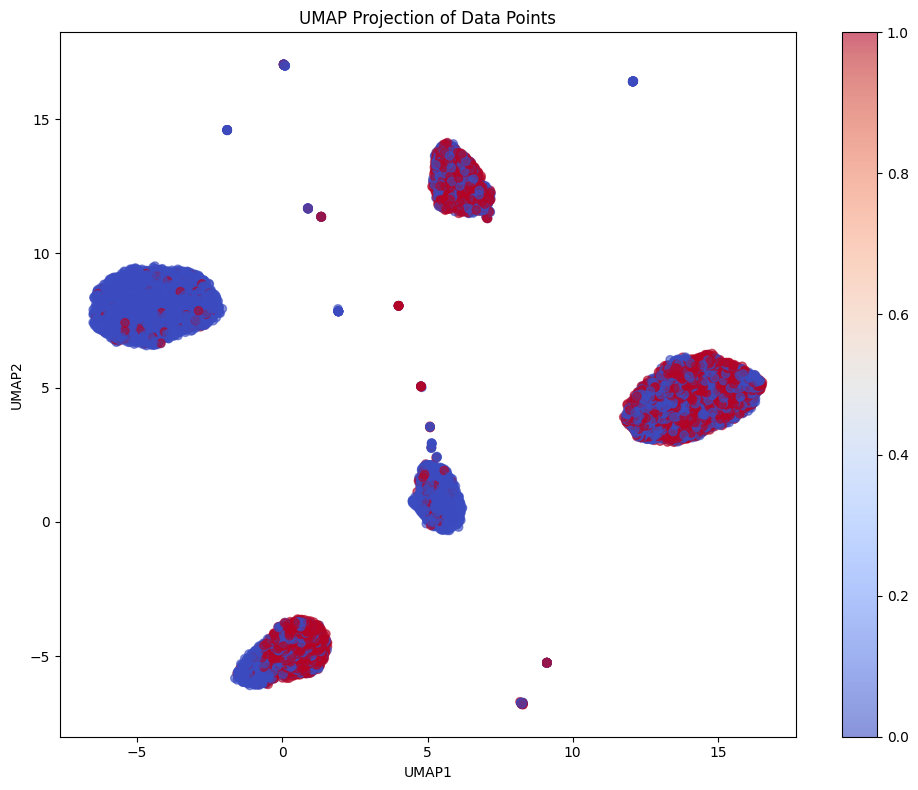

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap
import shap
import pickle

# 載入原始資料以進行視覺化
with open('model_checkpoints/raw_data.pkl', 'rb') as f:
    raw_data = pickle.load(f)
train_data = raw_data['train']

### 8.1 目標分佈分析
plt.figure(figsize=(10, 5))

# 繪製抽菸比例的countplot
plt.subplot(1, 2, 1)
sns.countplot(data=train_data, x='smoking')
plt.title('Smoking Distribution')
plt.xlabel('Smoking Status')
plt.ylabel('Count')

# 顯示具體數值和比例
smoking_dist = train_data['smoking'].value_counts(normalize=True)
plt.subplot(1, 2, 2)
sns.barplot(x=smoking_dist.index, y=smoking_dist.values)
plt.title('Smoking Distribution (%)')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage')
for i, v in enumerate(smoking_dist):
    plt.text(i, v, f'{v:.1%}', ha='center')
plt.tight_layout()
plt.show()

### 8.2 數值特徵分析
numerical_cols = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'HDL', 'LDL']

# Boxplots比較
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=train_data, x='smoking', y=col)
    plt.title(f'{col} by Smoking Status')
plt.tight_layout()
plt.show()

# KDE plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=train_data, x=col, hue='smoking')
    plt.title(f'{col} Distribution by Smoking Status')
plt.tight_layout()
plt.show()

### 8.3 類別特徵分析
categorical_cols = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']  # 修正欄位名稱


# 計算各類別特徵中的抽菸比例
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    smoking_ratio = train_data.groupby(col)['smoking'].mean()
    sns.barplot(x=smoking_ratio.index, y=smoking_ratio.values)
    plt.title(f'Smoking Ratio by {col}')
    plt.xlabel(col)
    plt.ylabel('Smoking Ratio')
    for j, v in enumerate(smoking_ratio):
        plt.text(j, v, f'{v:.2%}', ha='center')
plt.tight_layout()
plt.show()

### 8.4 特徵相關性分析
# 計算相關係數矩陣
numeric_data = train_data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

# 繪製相關係數熱圖
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### 8.5 特徵重要性分析
# XGBoost特徵重要性
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(xgb_model.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, xgb_model.feature_importances_[sorted_idx])
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# SHAP值分析
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train)
plt.tight_layout()
plt.show()

### 8.6 群聚分析視覺化
# UMAP降維
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_train)

# 繪製群聚散佈圖
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter)
plt.title('UMAP Projection of Data Points')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()